# **Step 1: Loading Datasets From MalariaGEN**

In [1]:
import pandas as pd

# URLs
genotype_url = "https://pf8-release.cog.sanger.ac.uk/Pf8_drug_resistance_marker_genotypes.tsv"
resistance_url = "https://pf8-release.cog.sanger.ac.uk/Pf8_inferred_resistance_status_classification.tsv"

# Load dataframes
genotypes = pd.read_csv(genotype_url, sep="\t")
resistance = pd.read_csv(resistance_url, sep="\t")

print("Genotypes Preview")
print(genotypes.head())

print("\nResistance Preview")
print(resistance.head())

Genotypes Preview
      Sample crt_72[C] crt_74[M] crt_75[N] crt_76[K] crt_72-76[CVMNK]  \
0   FP0008-C         C       I,M       E,N       T,K      CVIET,CVMNK   
1   FP0009-C         C         I         E         T            CVIET   
2  FP0010-CW         C       I,M       E,N       T,K      CVIET,CVMNK   
3  FP0011-CW         C       I,M       E,N       T,K      CVIET,CVMNK   
4  FP0012-CW         C         I         E         T            CVIET   

  crt_93[T] crt_97[H] crt_218[I] crt_220[A]  ... mdr1_1034[S] mdr1_1042[N]  \
0         T         H          I        S,A  ...            S            N   
1         T         H          I          S  ...            S            N   
2         T         H          I        S,A  ...            S            N   
3         T         H          I        S,A  ...            S            N   
4         T         H          I          S  ...            S            N   

  mdr1_1226[F] mdr1_1246[D] arps10_127-128[VD] fd_193[D] mdr2_484[T]  \
0 

In [2]:
print("Genotypes Info")
print(genotypes.info())

print("\nResistance Info")
print(resistance.info())

Genotypes Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24409 entries, 0 to 24408
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Sample                      24409 non-null  object
 1   crt_72[C]                   24409 non-null  object
 2   crt_74[M]                   24409 non-null  object
 3   crt_75[N]                   24409 non-null  object
 4   crt_76[K]                   24409 non-null  object
 5   crt_72-76[CVMNK]            24409 non-null  object
 6   crt_93[T]                   24409 non-null  object
 7   crt_97[H]                   24409 non-null  object
 8   crt_218[I]                  24409 non-null  object
 9   crt_220[A]                  24409 non-null  object
 10  crt_271[Q]                  24409 non-null  object
 11  crt_326[N]                  24409 non-null  object
 12  crt_333[T]                  24409 non-null  object
 13  crt_353[G]                  244

# **Step 2: Processing The Data**

In [3]:
import numpy as np

def process_genotype(value, wildtype):
    """
    Convert amino acid genotype calls into binary mutation indicators.

    Parameters:
    - value (str): genotype call (e.g. "N", "S,N", "-", "!")
    - wildtype (str): the reference amino acid (from column name, e.g. dhfr_108[S] → S)

    Returns:
    - 0 if wildtype only
    - 1 if mutation present
    - np.nan if missing/uncallable
    """
    if pd.isna(value):
        return np.nan

    # Missing or ambiguous calls
    if value in ["-", "*", "!"]:
        return np.nan

    # Split haplotypes (e.g. "S,N")
    alleles = value.split(",")

    # If ALL alleles are wildtype → no mutation
    if all(a == wildtype for a in alleles):
        return 0

    # If any allele differs → mutation
    return 1

In [4]:
# Copy genotype dataset
geno_proc = genotypes.copy()

# Iterate over genotype columns (skip "Sample")
for col in geno_proc.columns[1:]:
    if "[" in col:  # columns with wildtype info, e.g. dhfr_108[S]
        wildtype = col.split("[")[-1].replace("]", "")  # extract inside brackets
        geno_proc[col] = geno_proc[col].apply(lambda x: process_genotype(x, wildtype))

In [5]:
# Copy resistance dataset
res_proc = resistance.copy()

# Map resistance categories to binary
mapping = {
    "Resistant": 1,
    "Sensitive": 0,
    "Undetermined": np.nan
}

for col in res_proc.columns[1:]:  # skip "Sample"
    res_proc[col] = res_proc[col].map(mapping)

# **Step 3: Merge Datasets**

In [6]:
# Merge on Sample ID
merged = geno_proc.merge(res_proc, left_on="Sample", right_on="sample", how="inner")

print("Merged dataset shape:", merged.shape)
merged.head()

Merged dataset shape: (24409, 51)


,Sample,crt_72[C],crt_74[M],crt_75[N],crt_76[K],crt_72-76[CVMNK],crt_93[T],crt_97[H],crt_218[I],crt_220[A],...,Chloroquine,Pyrimethamine,Sulfadoxine,Mefloquine,Artemisinin,Piperaquine,SP (uncomplicated),SP (IPTp),AS-MQ,DHA-PPQ
0,FP0008-C,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FP0009-C,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,FP0010-CW,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,FP0011-CW,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,NaN,1.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,FP0012-CW,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# **Drug For ML Target (Artemisinin)**

In [7]:
# Define features (X) and target (y)
X = merged.drop(columns=["Sample", "Artemisinin"])
y = merged["Artemisinin"]

print("X shape:", X.shape)
print("y value counts:\n", y.value_counts())

X shape: (24409, 49)
y value counts:
 Artemisinin
0.0    17147
1.0     3905
Name: count, dtype: int64


In [8]:
# Check balance of Artemisinin resistance classes
print("Class distribution for Artemisinin resistance:")
print(y.value_counts(dropna=False))

# Check percentage distribution
print("\nPercentage distribution:")
print(y.value_counts(normalize=True, dropna=False) * 100)

Class distribution for Artemisinin resistance:
Artemisinin
0.0    17147
1.0     3905
NaN     3357
Name: count, dtype: int64

Percentage distribution:
Artemisinin
0.0    70.248679
1.0    15.998197
NaN    13.753124
Name: proportion, dtype: float64


In [9]:
# Drop rows where Artemisinin resistance is undetermined
mask = y.notna()
X_clean = X[mask]
y_clean = y[mask]
print(y_clean.value_counts(normalize=True) * 100)

Artemisinin
0.0    81.450694
1.0    18.549306
Name: proportion, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import numpy as np

# Drop rows where Artemisinin resistance is undetermined (already done in previous cell)
# mask = y.notna()
# X_clean = X[mask]
# y_clean = y[mask]

# Drop the problematic 'kelch13_349-726_ns_changes' column and the 'sample' column
X_clean = X_clean.drop(columns=['kelch13_349-726_ns_changes', 'sample'], errors='ignore')

# Impute missing values in X_clean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_clean_imputed = imputer.fit_transform(X_clean)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_clean_imputed, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Train Logistic Regression (with balanced class weights)
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      3430
         1.0       0.83      0.98      0.90       781

    accuracy                           0.96      4211
   macro avg       0.91      0.97      0.93      4211
weighted avg       0.96      0.96      0.96      4211


Confusion Matrix:
[[3269  161]
 [  17  764]]


<Figure size 500x400 with 0 Axes>

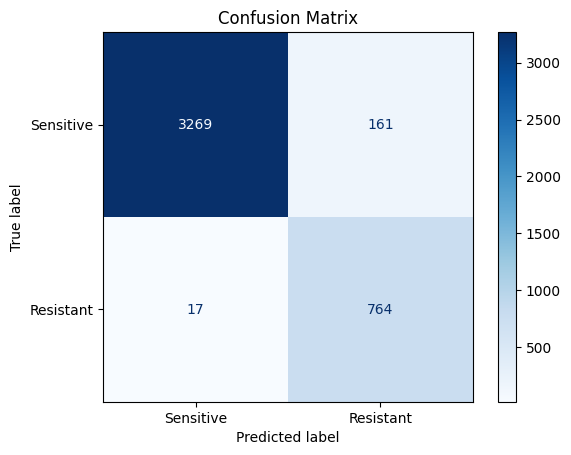

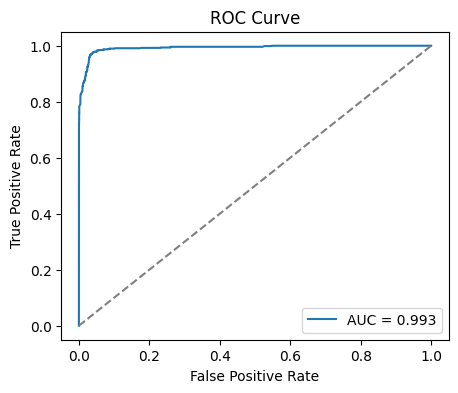

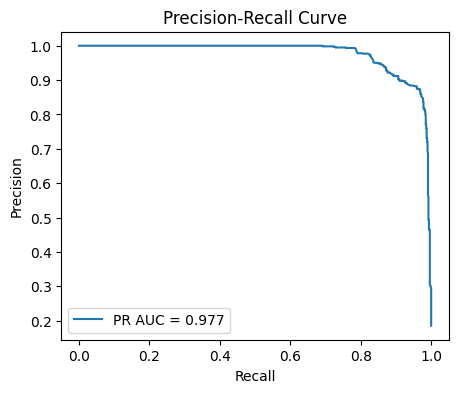

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc

y_proba = log_reg.predict_proba(X_test)[:, 1]

# --- Confusion Matrix ---
plt.figure(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Sensitive", "Resistant"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- Precision-Recall Curve ---
prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)

plt.figure(figsize=(5, 4))
plt.plot(rec, prec, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:05:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision (Resistant),Recall (Resistant),F1 (Resistant),ROC AUC
2,XGBoost,0.977915,0.942159,0.938540,0.940346,0.997194
1,Random Forest,0.977678,0.938697,0.941101,0.939898,0.994500
0,Logistic Regression,0.966279,0.919842,0.896287,0.907912,0.992265


<Figure size 1000x500 with 0 Axes>

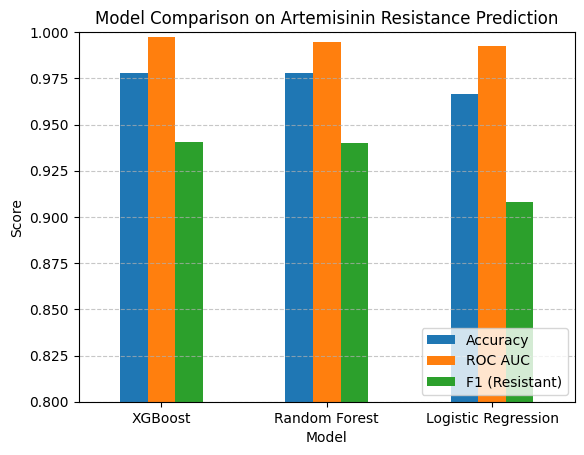

In [18]:
# Step 1: Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Define models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
}

# Step 3: Train, predict, and collect results
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # needed for ROC AUC

    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_prob)

    results.append({
        "Model": name,
        "Accuracy": report["accuracy"],
        "Precision (Resistant)": report["1.0"]["precision"],
        "Recall (Resistant)": report["1.0"]["recall"],
        "F1 (Resistant)": report["1.0"]["f1-score"],
        "ROC AUC": roc_auc
    })

# Step 4: Create a results table
results_df = pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False)
display(results_df)

# Step 5: Visualize model performance
plt.figure(figsize=(10, 5))
results_df.set_index("Model")[["Accuracy", "ROC AUC", "F1 (Resistant)"]].plot(kind="bar")
plt.title("Model Comparison on Artemisinin Resistance Prediction")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()